# Assigment

The following notebook contains the base architecture for the assignment.

The task is to complete the missing parts, explore the datasets and build two simple binary classifier, one which consists only of fully connected layers and one which also incorporates convolutional and max-pooling layers.

Only numpy is allowed to implement the classes! (Matplotlib and other modules can be used for visualization and data exploration.)

**Due date:** 2019 december 3

In [1]:
import numpy as np

# Optimizers

In [2]:
class Optimizer:
  def update(self, param, grad):
    pass
  
  def __call__(self, param, grad):
    self.update(param, grad)
  
  
class SGD(Optimizer):
  def __init__(self, learning_rate):
    self.learning_rate = learning_rate
  
  def update(self, param, grad):
    '''Gradient Descent Update
    This function updates the given 'param' using the 'grad' (gradients). 
    Note #1: Use the learning_rate. 
    Note #2: There are no return values.
    
    :param param: Parameters of the layer.
    :param grad: Corresponding gradients.
    '''
    
    return param - self.learning_rate * grad
    
    
    # TODO

# Weight Initializers

In [3]:
# DONE


class WeigthInitializer:
  def initialize(self, size):
    return np.ones(size, dtype=np.float)
  
  def __call__(self, size):
    return self.initialize(size)
  

class RandomInitializer(WeigthInitializer):
  def __init__(self, shift=-0.5, scale=0.2):
    self.shift = shift
    self.scale = scale
    
  def initialize(self, size):
    '''Random number initializer
    Note #1: 'self.scale' specifies the range of the values and with 'self.shift' they can be shifted.
    Note #2: By default (with scale=0.2 and shift=-0.5) it should return a matrix which contains random values between -0.1 and 0.1. 
    Note #3: Use the np.random module!

    :param size: Dimensions of the matrix.
    :returns: A matrix of random numbers with dimensions specified by 'size'. 
    '''
    return np.random.normal(0.0,self.scale*(-1)*self.shift,size)

# Function class

In [4]:
class Function:
  def forward(self, input):
    return None  
  
  def __call__(self, input):
    return self.forward(input)
  
  def backward(self, grads):
    return None

## Activation functions

In [5]:
# DONE

class Activation(Function):
  def __init__(self):
    pass
  
  
class Linear(Activation):
  def forward(self, z):
    return z.astype(np.float)

  def backward(self, z):
    return np.ones_like(z, dtype=np.float)


class Relu(Activation):
  
  def forward(self, z):
    '''Forward pass of the Rectified Linear Unit activation function.

    :param z: Input tensor.
    :returns: ReLU(z), see the lecture notes for the definition. 
    '''
    z = np.maximum(0,z)  
    return z

  def backward(self, z):
    '''Backward pass of the Rectified Linear Unit activation function.

    :param z: Input tensor.
    :returns: ReLU'(z), see the lecture notes for the definition. 
    '''
    z[z<=0] = 0
    z[z>0] = 1

    return z  

  
class Sigmoid(Activation):
  

  def forward(self, z):
    '''Forward pass of the Sigmoid activation function.

    :param z: Input tensor.
    :returns: sigmoid(z), see the lecture notes for the definition. 
    '''
    z = (1/(1+np.exp(-z)))
    return z
  
  def backward(self, z):
    '''Backward pass of the Sigmoid activation function.

    :param z: Input tensor.
    :returns: sigmoid'(z), see the lecture notes for the definition. 
    '''
    z = 1/(1+np.exp(-z)) * (1.0 - 1/(1+np.exp(-z)))  
    
    return z

## Loss functions

In [6]:
class Loss(Function):
  def forward(self, y_true, y_pred):
    return None
  
  def __call__(self, y_true, y_pred):
    return self.forward(y_true, y_pred)
  
  def backward(self, y_true, y_pred):
    return None
  
  
class BinaryCrossentropy(Loss):
  
  def forward(self, y_true, y_pred):
    '''Forward pass of the Binary Crossentropy loss.
    Note: Both 'y_true' and 'y_pred' contains a batch of labels => y_true.shape == y_pred.shape == <batch size> x 1 

    :param y_true: Ground truth labels.
    :param y_pred: Predicted labels.
    :returns: Binary crossentropy loss, see the lecture notes for the definition. 
    '''
    
    assert y_true.shape == y_pred.shape
    
   
    ce = np.mean(-1*y_true*np.log10(y_pred)-(1-y_true)*np.log10(1-y_pred))
    
    
    return ce
  
  def backward(self, y_true, y_pred):
    '''Backward pass of the Binary Crossentropy loss.
    Note #1: The gradient should have the same shape as y_pred (<batch size> x 1) 
    Note #2: Keep in mind that the derivative of the loss in the lecture notes is for a logistic regression model. 
    Note #3: Here, you do not need to derive respect to the weights! 

    :param y_true: Ground truth labels.
    :param y_pred: Predicted labels.
    :returns: Derivative of the binary crossentropy loss, see the lecture notes for the "definition". 
    '''

    dce = y_true*(y_pred-1) + (1-y_true)*y_pred
      
    dce = dce.reshape(y_true.shape[0],1)

    return dce

## Layers

In [7]:
class Layer(Function):
  def __init__(self, activation, optimizer=None, weight_init=RandomInitializer(), *args, **kwargs):
    self.activation = activation
    self.optimizer = optimizer
    self.weight_init = weight_init
  
  def _forward(self, x):
    return None
  
  def forward(self, X):
    self.X = X
    
    self.Z = self._forward(X)
    self.h = self.activation(self.Z)
    return self.h
  
  def _backward(self, dZ):
    return None, None
  
  def backward(self, dh):
    #print(dh.shape)
    dZ = dh * self.activation.backward(self.Z) 
    self.dX, self.grads = self._backward(dZ)
    self._update_weights()
    return self.dX
  
  def _update_weights(self):
    assert len(self.params) == len(self.grads)
    #for idx in range(len(self.params)):
        #print("Before optimizer update with idx: " +str(idx)+ "  "+str(self.params[idx]))
    
    self.W = self.optimizer.update(self.W, self.grads[0])
    self.b = self.optimizer.update(self.b,self.grads[1])
    
        #print("AFTER optimizer update with idx: "+ str(idx)+ "  "+str(self.params[idx]))

### Fully-connected (dense) layer

In [8]:
class Dense(Layer):
  def __init__(self, size, *args, **kwargs):
    super(Dense, self).__init__(*args, **kwargs)
    self.W = self.weight_init(size)
    self.b = self.weight_init((1, size[1]))
    self.params = [self.W, self.b]
    
  def _forward(self, X):
    '''Forward pass of the dense layer.
    Note #1: Use self.W and self.b
    Note #2: Input times weight add a bias ==> activate is already taken care of! (see self.forward())

    :param X: Input matrix
    :returns: Linear combination, see the lecture notes for the definition.
    '''
    return np.dot(X,self.W) + self.b  # TODO

  def _backward(self, dZ):
    '''Backward pass of the dense layer.
    Note: Use self.X

    :param dZ: Gradient of the subsequent layer.
    :returns: A pair (dX and [dW, db]) which contains the partial derivatives respect to the input and to the parameters (W and b). See the lecture notes for the "definition".
    '''
    dW = np.dot(self.X.T,dZ)  #TODO
    db = dZ.mean(axis=0)   #TODO
    dX = np.dot(dZ,self.W.T)  #TODO
    return dX, [dW, db]

### Flatten

In [9]:
class Flatten(Layer):
  def __init__(self, *args, **kwargs):
    super(Flatten, self).__init__(activation=Linear(), *args, **kwargs)
  
  def _forward(self, X):
    return X.reshape((len(X), -1))

  def _backward(self, dZ):
    return dZ.reshape(self.X.shape), []
  
  def _update_weights(self):
    pass

# Model class

In [10]:
import matplotlib.pyplot as plt
class Model:
  def __init__(self, layers=None, loss=None, optimizer=None):
    self.layers = []
    if layers is not None:
      self.layers = layers
    self.loss = loss
    self.optimizer = optimizer
  
  def add(self, layer):
    assert isinstance(layer, Layer)
    layer.optimizer = self.optimizer
    self.layers.append(layer)
  
  def train(self, x_train, y_train, n_epochs, batch_size, randomize=True, display=True):
    self.losses = []
    
    for epoch in range(n_epochs):
      idx_list = list(range(len(x_train)))
      if randomize:
        np.random.shuffle(idx_list)
      n_batches = (len(idx_list) + batch_size - 1) // batch_size
      loss = 0.
      for batch_idx in range(n_batches):
        
        data = x_train[idx_list[batch_idx * batch_size:(batch_idx + 1) * batch_size]]
        
        
        
        # TODO forward pass
        
        for l in range(len(self.layers)):
          
          data = self.layers[l].forward(data)
       
        # loss
        data = np.reshape(data,data.shape[0])
        
        
        y_pred = data
        y_true = y_train[idx_list[batch_idx * batch_size:(batch_idx + 1) * batch_size]]
        batch_loss = self.loss(y_true, y_pred)
        loss += batch_loss

        # TODO backward pass
        grad_batch_loss = self.loss.backward(y_true,y_pred)
        for l in range(len(self.layers))[::-1]:
          #print(l)
          grad_batch_loss = self.layers[l].backward(grad_batch_loss)
        # display
      
      print('Epoch {}/{}: loss: {}'.format(epoch+1, n_epochs, loss/n_batches))
      self.losses.append(loss / n_batches)
    if display:
      

      plt.plot(self.losses)
      plt.show()
      pass # TODO Plot the learning curve after training.
  
  def predict(self, x_test,x_labels ,display=True):
    data =x_test
    for l in range(len(self.layers)):
        data = self.layers[l].forward(data)
    print("TEST LOSS: {}".format(self.loss(x_labels,data)))
    pass  # TODO (hint: forward pass)

# Breast Cancer Wisconsin (Diagnostic) Dataset

For more information, see: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)

In [40]:
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data

In [41]:
filename = 'wdbc.data'

with open(filename, 'r') as file:
  lines = file.readlines()
  
words = [line.split(',') for line in lines]
print(words)
data = words[:-1]
print(data)
features = [[float(item) for item in rec[2:]] for rec in data]
features = np.array(features, dtype=np.float32)

label_str_to_num = lambda label: 1. if label == 'M' else 0.
labels = [label_str_to_num(rec[1]) for rec in data]
labels = np.array(labels, dtype=np.float32)

# removing records with missing features (if any feature == 0.)
missing_features = np.any(features == 0., axis=1)
features = features[~missing_features,:]
labels = labels[~missing_features]

print(features.shape)
print(labels.shape)

[['842302', 'M', '17.99', '10.38', '122.8', '1001', '0.1184', '0.2776', '0.3001', '0.1471', '0.2419', '0.07871', '1.095', '0.9053', '8.589', '153.4', '0.006399', '0.04904', '0.05373', '0.01587', '0.03003', '0.006193', '25.38', '17.33', '184.6', '2019', '0.1622', '0.6656', '0.7119', '0.2654', '0.4601', '0.1189\n'], ['842517', 'M', '20.57', '17.77', '132.9', '1326', '0.08474', '0.07864', '0.0869', '0.07017', '0.1812', '0.05667', '0.5435', '0.7339', '3.398', '74.08', '0.005225', '0.01308', '0.0186', '0.0134', '0.01389', '0.003532', '24.99', '23.41', '158.8', '1956', '0.1238', '0.1866', '0.2416', '0.186', '0.275', '0.08902\n'], ['84300903', 'M', '19.69', '21.25', '130', '1203', '0.1096', '0.1599', '0.1974', '0.1279', '0.2069', '0.05999', '0.7456', '0.7869', '4.585', '94.03', '0.00615', '0.04006', '0.03832', '0.02058', '0.0225', '0.004571', '23.57', '25.53', '152.5', '1709', '0.1444', '0.4245', '0.4504', '0.243', '0.3613', '0.08758\n'], ['84348301', 'M', '11.42', '20.38', '77.58', '386.1', 

## Data exploration and Pre-processing
Tasks:
* Print the distribution of the labels.
* Print the scales of each features. (min, max, avg, std)
* Randomly split the dataset to training and test sets. (Ratio should be 80-20.)
  * After splitting make sure that the distribution of the labels are similar. (Print the distribution of the labels.)
* Normalize the data by each feature. (Use Z-score standardization.)

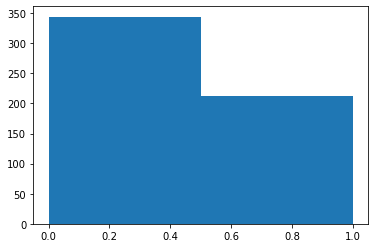

In [42]:
import matplotlib.pyplot as plt
hist = plt.hist(labels, bins=2)
plt.show()

#### Printing statistics

In [43]:
# TODO

i=0;
for f in features:
  print(str(i)+"--> Min: "+ str(min(f)) + " Max : "+str(max(f))+" Average: "+str(sum(f) / len(f))+" STD: "+str(np.std(f)))
  i+=1

0--> Min: 0.006193 Max : 2019.0 Average: 118.87261579313005 STD: 397.01315
1--> Min: 0.003532 Max : 1956.0 Average: 124.69744885278244 STD: 415.05103
2--> Min: 0.004571 Max : 1709.0 Average: 112.91308502281706 STD: 366.8095
3--> Min: 0.00911 Max : 567.7 Average: 41.33339564797158 STD: 120.8476
4--> Min: 0.005115 Max : 1575.0 Average: 111.22280742493459 STD: 357.93338
5--> Min: 0.005082 Max : 741.6 Average: 50.184842846294245 STD: 155.0806
6--> Min: 0.002179 Max : 1606.0 Average: 102.2645785630215 STD: 336.1452
7--> Min: 0.005412 Max : 897.0 Average: 60.481265489198265 STD: 187.3967
8--> Min: 0.003749 Max : 739.3 Average: 52.16324036926962 STD: 158.7965
9--> Min: 0.007149 Max : 711.4 Average: 49.78114739990172 STD: 150.33418
10--> Min: 0.003042 Max : 1150.0 Average: 77.08483130223273 STD: 245.66634
11--> Min: 0.004144 Max : 1299.0 Average: 82.10649843557427 STD: 266.40576
12--> Min: 0.003139 Max : 1332.0 Average: 98.94902585100694 STD: 305.40277
13--> Min: 0.003002 Max : 876.5 Average: 

#### Splitting Dataset 

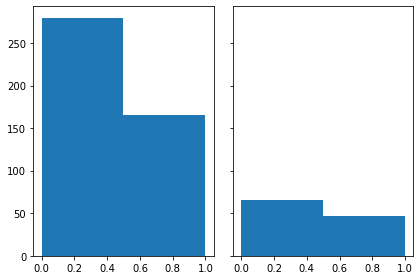

In [44]:
c = np.c_[features.reshape(len(features), -1), labels.reshape(len(labels), -1)]
np.random.shuffle(c)

train, test = np.split(c, [int(0.8 * len(c))])


train_features = train[:,:-1]
train_labels = train[:,-1]

test_features = test[:,:-1]
test_labels = test[:,-1]

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

axs[0].hist(train_labels, bins=2)
axs[1].hist(test_labels, bins=2)

plt.show()

#### Z-score Standarization

In [45]:

mn = np.mean(train_features)
std = np.std(train_features)
#for i in range(train_features.shape[1]):
#  mn.append(np.mean(train_features[:][i]))
#  std.append(np.std(train_features[:][i]))
#for i in range(train_features.shape[1]):
#    
#    train_features[:][i] = (train_features[:][i] - mn[i]) / std[i]
    
#for i in range(test_features.shape[1]):
#    test_features[:][i] = (test_features[:][i] - mn[i]) / std[i]

train_features = (train_features - np.mean(train_features)) /  np.std(train_features)
test_features = (test_features - mn) / std

In [46]:
print(train_features)

[[-0.20506893 -0.18871889  0.16092071 ... -0.27239612 -0.27160412
  -0.27247152]
 [-0.21261512 -0.1829942   0.11655437 ... -0.27247083 -0.27179232
  -0.27239943]
 [-0.23077366 -0.18889236 -0.00800093 ... -0.2726009  -0.27166092
  -0.27242422]
 ...
 [-0.21187784 -0.2034643   0.11659775 ... -0.27244446 -0.2715859
  -0.27245396]
 [-0.22202615 -0.18988985  0.0495929  ... -0.27251872 -0.27125543
  -0.27246594]
 [-0.21634485 -0.17640215  0.08290017 ... -0.27272755 -0.27177238
  -0.27251428]]


## Define and train a model.
Tasks:
* Define a 2 layer fully-connected network:
  1. layer with 5 units and ReLU activation.
  2. layer with 1 units and Sigmoid activation.
* Train it for 500 epochs with a batch size of 16 using SGD optimizer with learning rate of 0.01.
* Plot the learning curve.
  * Summmarize in a few words what you see. (Presence of overfitting, underfitting, ...)
* Evaluate the trained model on the test set. (Loss, accuracy, precision, recall)

Epoch 1/100: loss: 0.2955214121909227
Epoch 2/100: loss: 0.2854258705702246
Epoch 3/100: loss: 0.2704996071166807
Epoch 4/100: loss: 0.2506228326556636
Epoch 5/100: loss: 0.22853688196236868
Epoch 6/100: loss: 0.2041737955771035
Epoch 7/100: loss: 0.1821988961732495
Epoch 8/100: loss: 0.16426245934597092
Epoch 9/100: loss: 0.14881135958150832
Epoch 10/100: loss: 0.13675449323887187
Epoch 11/100: loss: 0.12846597286097192
Epoch 12/100: loss: 0.12044957178928503
Epoch 13/100: loss: 0.11543030989704543
Epoch 14/100: loss: 0.11124776632543129
Epoch 15/100: loss: 0.10747709524197768
Epoch 16/100: loss: 0.10344025086741572
Epoch 17/100: loss: 0.10016861090542632
Epoch 18/100: loss: 0.09772482348547969
Epoch 19/100: loss: 0.09559757966619085
Epoch 20/100: loss: 0.09244753741481597
Epoch 21/100: loss: 0.09071668701310977
Epoch 22/100: loss: 0.09029230368932183
Epoch 23/100: loss: 0.08829888987976978
Epoch 24/100: loss: 0.08651835741891431
Epoch 25/100: loss: 0.08616244092474372
Epoch 26/100: l

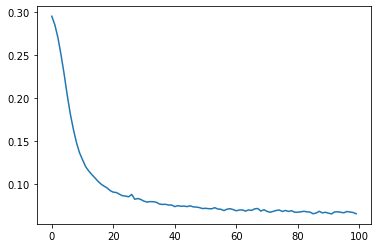

TEST LOSS: 0.11307667755933425


In [47]:
np.random.seed(150)
# TODO
f_loss = BinaryCrossentropy()
f_opt = SGD(learning_rate = 0.01)
model = Model(loss = f_loss,optimizer = f_opt )
model.add(Dense([train_features.shape[1],5],Relu()))
model.add(Dense([5,1],Sigmoid()))

model.train(train_features,train_labels,100,16)

model.predict(test_features,test_labels.reshape(test_labels.shape[0],1))


# Triangles vs Circles (Basic Shapes Dataset)

For more information, see: https://www.kaggle.com/cactus3/basicshapes

### Convolutional layer


In [11]:
class Conv2d(Layer):
  def __init__(self, kernel_size, n_channels, n_kernels, pad, use_fast=False, *args, **kwargs):    
    super(Conv2d, self).__init__(*args, **kwargs)
    self.W = self.weight_init((kernel_size, kernel_size, n_channels, n_kernels))
    self.b = self.weight_init((1, 1, 1, n_kernels))
    self.params = [self.W, self.b]
    self.pad = pad
    self.use_fast = use_fast
  
  def _convolution_fast(self, Y):
    '''Optimized version of the convolution operation (Optional).
    Note #1: Use self.X, self.X_padded, self.W
    Note #2: There are no return values.
    Note #3: It's an optional task.
    
    :param Y: Destination (output) matrix (image), see the lecture notes for the "definition". 
    '''    
    pass  # TODO optional
    
  def _convolution_slow(self, Y):
    '''Naive version (with a bunch of for loops) of the convolution operation.
    Note #1: Use self.X, self.X_padded, self.W
    Note #2: There are no return values.
    Note #3: Both convolution and cross-correlation is acceptable.
    
    :param Y: Destination (output) matrix (image), see the lecture notes for the "definition". 
    '''    
    batch_size = self.X_padded.shape[0]
    Y_height = Y.shape[1]
    Y_width = Y.shape[2]
    Y_kernels = self.W.shape[3]
    X_channels = self.W.shape[2]
    W_height = self.W.shape[1]
    W_width = self.W.shape[2]
    
    for b in range(batch_size):
      for h in range(Y_height):
        for w in range(Y_width):
          for k in range(Y_kernels):
            
            for c in range(X_channels):
              for a in range(W_height): # -1 to 1
                for b in range(W_width): # -1 to 1
                  
                  Y[b,h,w,k] = Y[b,h,w,k] + self.X_padded[b,h+a,w+b,c] * self.W[a,b,c,k]
    
    
    pass  # TODO

  def _forward(self, X):
    y_height = X.shape[1] - self.W.shape[0] + 2*self.pad + 1
    y_width = X.shape[2] - self.W.shape[1] + 2*self.pad + 1
    Y = np.zeros((X.shape[0], y_height, y_width, self.W.shape[3]), dtype=np.float16)
    
    if 0 < self.pad:
        X_padded = np.pad(X,self.pad,mode='constant')  # TODO pad the input
    else:
        X_padded = X
    self.X_padded = X_padded
    
    if self.use_fast:
        self._convolution_fast(Y)
    else:
        self._convolution_slow(Y)
    
    Y += self.b
    return Y
  
  def _backward_fast(self, dZ):
    '''Optimized version of the backward pass (Optional).
    Note #1: Use self.X, self.X_padded, self.W
    Note #2: It's an optional task.
    
    :param dZ: Gradient of the subsequent layer.
    :returns: A pair (dX, dW and db) which contains the partial derivatives respect to the input and to the parameters (W and b). See the lecture notes for the "definition".
    '''    
    db = None  # None optional
    dW = None  # None optional
    dX = None  # None optional
    return dX, dW, db

  def _backward_slow(self, dZ):
    '''Naive version (with a bunch of for loops) of the backward pass.
    Note: Use self.X, self.X_padded, self.W
    
    :param dZ: Gradient of the subsequent layer.
    :returns: A pair (dX, dW and db) which contains the partial derivatives respect to the input and to the parameters (W and b). See the lecture notes for the "definition".
    ''' 
    #print("In convol back")
    dX = np.zeros_like(self.X)
    dW = np.zeros_like(self.W)
    db = np.zeros_like(self.b)
    ### calculate db:
    db = np.sum(dZ, axis=(0, 1, 2))
    
    batch_size = self.X_padded.shape[0]
    Y_height = self.X_padded.shape[1] - 2
    Y_width = self.X_padded.shape[2] - 2
    Y_kernels = self.W.shape[3]
    X_channels = self.W.shape[2]
    W_height = self.W.shape[0]
    W_width = self.W.shape[1]
    
    ### calculate dW:
    
    for b in range(batch_size):       
        for k in range(Y_kernels):   
            for h in range(Y_height): 
                for w in range(Y_width):
                  
                    for c in range(X_channels):
                        for a in range(W_height):
                            for b in range(W_width):
                                dW[a,b,c,k] += self.X_padded[b,h+a, w+b,c] * dZ[b, h, w, c]
    
    
    ### calculate dX:
    
    dZpad = np.pad(dZ, ((0,),(W_width-1, ), (W_height-1,), (0,)), 'constant') #pad dZ
    
    dXpad = np.pad(dX, ((0,),(self.pad, ),(self.pad,), (0,)), 'constant') # pad dX
    
    
    w_ = np.zeros_like(self.W)
    for i in range(W_height):
        for j in range(W_width):
            w_[i,j,:,:] = w_[W_height-i-1,W_width-i-1,:,:]
            
    for b in range(batch_size):       
        for k in range(Y_kernels):   
            for h in range(Y_height+2*self.pad): #+2*self.pad
                for w in range(Y_width+2*self.pad): #+2*self.pad
                    for a in range(W_height): 
                        for b in range(W_width):
                            for c in range(X_channels): 
                                dXpad[b,h,w,c] += dZpad[b, h+a, w+b, k] * w_[a, b, c, k]
    
    
    #Remove padding for dx
    dX = dXpad[:,self.pad:-self.pad,self.pad:-self.pad,:]
    #print(dX.shape)
    return dX, dW, db
  
  def _backward(self, dZ):
    if self.use_fast:
      dX, dW, db = self._backward_fast(dZ)
    else:
      dX, dW, db = self._backward_slow(dZ)
    
    #if 0 < self.pad:
      #dX = dX[:, self.pad:-self.pad, self.pad:-self.pad, :]
    
    return dX, [dW, db]
    

### Max pooling

In [12]:
class Maxpool2d(Layer):
  def __init__(self, *args, **kwargs):
    super(Maxpool2d, self).__init__(activation=Linear(), *args, **kwargs)
  
  def _forward(self, X):
    '''Forward pass of the max pooling layer.

    :param X: Input matrix
    :returns: Matrix (<batch_size> x <height>//2 x <width>//2 x <n_channels>) after max pooling, see the lecture notes for the definition.
    '''    
    batch_size = X.shape[0]
    pool_out = np.zeros((batch_size,int(X.shape[1]/2),int(X.shape[2]/2),X.shape[3]))
    
    for b in range(batch_size):
      for c in range(X.shape[3]):
        r2 = 0
        for r in np.arange(0,X.shape[1],2):
          k2 = 0
          for k in np.arange(0,X.shape[2],2):
            pool_out[b,r2,k2,c] = np.max(X[b,r:r+2,k:k+2,c])
            k2+=1
        r2+=1
    
    
    
    
    
    self.mask = X  # TODO save the mask for later (_backward) use.
    return pool_out  # TODO

  def _backward(self, dZ):
    '''Backward pass of the max pooling layer.
    Note: Use self.mask too.

    :param dZ: Gradient of the subsequent layer.
    :returns: A pair (dX and []) which contains the partial derivative respect to the input and an empty list. See the lecture notes for the "definition".
    '''
    #print("In Maxpool back")
    X_prev = self.mask
    
    batch_size, X_height, X_width, X_channels = X_prev.shape
    batch_size, Z_height, Z_width, Z_channels = dZ.shape
    
    dX = np.zeros(X_prev.shape)
    
    
    for i in range(batch_size):                       # loop over the training examples
        # select training example from A_prev (≈1 line)
        x = X_prev[i]
        for h in range(Z_height):                   # loop on the vertical axis
            for w in range(Z_width):               # loop on the horizontal axis
                for c in range(Z_channels):           # loop over the channels (depth)
                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = h
                    vert_end = vert_start + 2
                    horiz_start = w
                    horiz_end = horiz_start + 2
                    
                    
                   
                    # Use the corners and "c" to define the current slice from a_prev (≈1 line)
                    x_prev_slice = x[vert_start:vert_end, horiz_start:horiz_end, c]
                    # Create the mask from a_prev_slice (≈1 line)
                    mask = x_prev_slice == np.max(x_prev_slice)
                    # Set dA_prev to be dA_prev + (the mask multiplied by the correct entry of dA) (≈1 line)
                    dX[i, vert_start:vert_end, horiz_start:horiz_end, c] += np.multiply(mask, dZ[i, h, w, c])
 
    
    
    #print(dX.shape)
    
    
    return dX, []
  
  def _update_weights(self):
    pass

In [50]:
#!curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=1Va88vwMwmToi0SFfdTo8_9TJsV4qdOXK" > /dev/null
#!curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk '/download/ {print $NF}' ./cookie`&id=1Va88vwMwmToi0SFfdTo8_9TJsV4qdOXK" -o circles_vs_triangles_data.pkl

In [13]:
import pickle

with open('circles_vs_triangles_data.pkl', 'rb') as f:
    data = pickle.load(f)
features, labels = data['features'], data['labels']

print(features.shape)


(200, 28, 28, 1)


## Data exploration and Pre-processing
Tasks:
* Print the distribution of the labels.
* Plot some images (3 circles and 3 triangles).
* Randomly split the dataset to training and test sets. (Ratio should be 80-20.)
  * After splitting make sure that the distribution of the labels are similar. (Print the distribution of the labels.)
* Normalize the data between -1. and 1. (Use min-max scaling.)

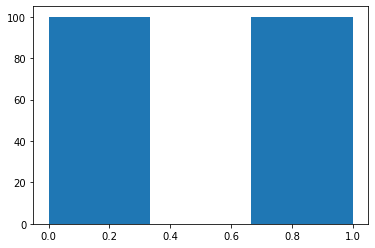

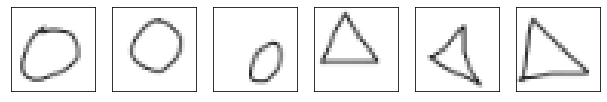

(200, 28, 28, 1)


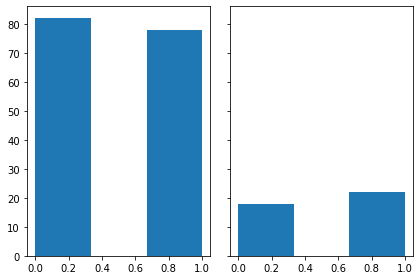

(160, 784)
(40, 784)
(160, 28, 28, 1)
(40, 28, 28, 1)


In [14]:
### LABEL DISTRIBUTION
import cv2
hist = plt.hist(labels, bins=3)
plt.show()
### PRINT THE IMAGES
class_names = np.unique(labels)
num_classes = len(class_names)
fig = plt.figure(figsize=(16,16))
k=0
for i in range(num_classes):
    if i == 0:
      p = 0
      t = 99
    else:
      p = 100
      t = 199
    p = np.random.randint(low=p, high=t, size=3)
    for l in p:
      k+=1
      ax = fig.add_subplot(6, 9, 1 + k, xticks=[], yticks=[])
      plt.imshow(cv2.cvtColor(features[l],cv2.COLOR_BGR2RGB))

plt.show()

### SPLIT INTO TRAIN AND TEST
print(features.shape)
c = np.c_[features.reshape(len(features), -1), labels.reshape(len(labels), -1)]
np.random.shuffle(c)

train, test = np.split(c, [int(0.8 * len(c))])


train_features = train[:,:-1]
train_labels = train[:,-1]

test_features = test[:,:-1]
test_labels = test[:,-1]

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

axs[0].hist(train_labels, bins=3)
axs[1].hist(test_labels, bins=3)

plt.show()

train_features =  (train_features - np.min(train_features)) / (np.max(train_features)-np.min(train_features))

print(train_features.shape)
print(test_features.shape)

train_features = np.reshape(train_features,(train_features.shape[0],28,28,1))
print(train_features.shape)
test_features = np.reshape(test_features,(test_features.shape[0],28,28,1))
print(test_features.shape)

## Define and train a model.
Tasks:
* Define a simple convolutional network as follows: 2x(Conv2D with 4 [then 8 in the second time] (3x3) kernels -> ReLU -> MaxPooling2D) -> Flatten -> Dense with 32 units -> Relu -> Dense -> Sigmoid
* Train it for 100 (or less if it is too slow...) epochs with a batch size of 16 using SGD optimizer with learning rate of 0.01.
  * Optional: Also train it with the optimized implementation, and measure the speed up. 
* Plot the learning curve.
  * Summmarize in a few words what you see. (Presence of overfitting, underfitting, ...)
* Evaluate the trained model on the test set. (Loss, accuracy, precision, recall)

Epoch 1/5: loss: 0.30100971100562396
Epoch 2/5: loss: 0.30101654029585834
Epoch 3/5: loss: 0.30100154375722366
Epoch 4/5: loss: 0.3009701883609482
Epoch 5/5: loss: 0.3009415815356244


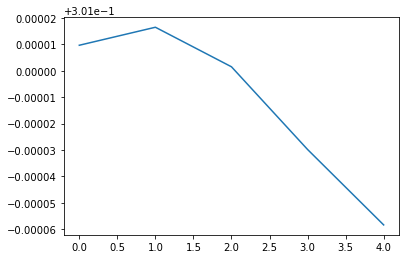

In [15]:
np.random.seed(42)

f_loss = BinaryCrossentropy()
f_opt = SGD(learning_rate = 0.01)
model = Model(loss = f_loss,optimizer = f_opt )
model.add(Conv2d(kernel_size=3,n_channels=1,n_kernels=4,pad=1,activation=Relu()))
model.add(Maxpool2d())
model.add(Conv2d(kernel_size=3,n_channels=1,n_kernels=8,pad=1,activation=Relu()))
model.add(Maxpool2d())
model.add(Flatten())
model.add(Dense([392,32],Relu()))
model.add(Dense([32,1],Sigmoid()))

model.train(train_features,train_labels,5,16)

#model.predict(test_features,test_labels.reshape(test_labels.shape[0],1))


# TODO

The model does not learn anything over the iterations.</br>
After testing and printing the results on all the layers, the problem is situated in the gradient of the weights, and the weights are not changing at all.</br>
A reason might be that the initialization of the weights is poor, maybe try He or  Xavier?